<!-- dom:TITLE: From Variational Monte Carlo to Boltzmann Machines and Machine Learning. Notebook 1:  Variational Monte Carlo -->
# From Variational Monte Carlo to Boltzmann Machines and Machine Learning. Notebook 1:  Variational Monte Carlo
<!-- dom:AUTHOR: Morten Hjorth-Jensen  Email hjensen@msu.edu  Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University, East Lansing, 48824 MI, USA -->
<!-- Author: -->  
**Morten Hjorth-Jensen  Email hjensen@msu.edu  Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University, East Lansing, 48824 MI, USA**

Date: **Mar 21, 2019**

Copyright 1999-2019, Morten Hjorth-Jensen  Email hjensen@msu.edu  Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University, East Lansing, 48824 MI, USA. Released under CC Attribution-NonCommercial 4.0 license




## Introduction

### Structure and Aims

These notebooks serve the aim of linking traditional variational Monte
Carlo VMC calculations methods with recent progress on solving
many-particle problems using Machine Learning algorithms.

Furthermore, when linking with Machine Learning algorithms, in particular
so-called Boltzmann Machines, there are interesting connections between
these algorithms and so-called [Shadow Wave functions (SWFs)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.90.053304) (and references therein). The implications of the latter have been explored in various Monte Carlo calculations. 

In total there are three notebooks:
1. the one you are reading now on Variational Monte Carlo methods, 

2. notebook 2 on Machine Learning and quantum mechanical problems and in particular on Boltzmann Machines, 

3. and finally notebook 3 on the link between Boltzmann machines and SWFs. 

### This notebook

In this notebook the aim is to give you an introduction as well as an
understanding of the basic elements that are needed in order to
develop a professional variational Monte Carlo code. We will focus on
a simple system of two particles in an oscillator trap (or
alternatively two fermions moving in a Coulombic potential). The particles can
interact via a repulsive or an attrative force.

The advantage of these systems is that for two particles (boson or
fermions) we have analytical solutions for the eigenpairs of the
non-interacting case. Furthermore, for a two- or three-dimensional
system of two electrons moving in a harmonic oscillator trap, we have
[analytical solutions for the interacting case as well](https://iopscience.iop.org/article/10.1088/0305-4470/27/3/040/meta).  

Having analytical eigenpairs is an invaluable feature that allows us 
to assess the physical relevance of the trial wave functions, be
these either from a standard VMC procedure, from Boltzmann Machines or
from Shadow Wave functions.

In this notebook we start with the basics of a VMC calculation and
introduce concepts like Markov Chain Monte Carlo methods and the
Metropolis algorithm, importance sampling and Metropolis-Hastings
algorithm, resampling methods to obtain better estimates of the
statistical errors and minimization of the expectation values of the
energy and the variance. The latter is done in order to obtain the
best possible variational parameters. Furthermore it will define the
so-called **cost** function, a commonly encountered quantity in Machine
Learning algorithms. Minimizing the latter is the one which leads to
the determination of the optimal parameters in basically all Machine Learning algorithms.
For our purposes, it will serve as the first link between VMC methods and Machine Learning methods.

Topics like Markov Chain Monte Carlo and various resampling techniques
are also central to Machine Learning methods. Presenting them in the
context of VMC approaches leads hopefully to an easier starting point
for the understanding of these methods.

Finally, the reader may ask what do we actually want to achieve with
complicating life with Machine Learning methods when we can easily
study interacting systems with standard Monte Carlo approaches.  Our
hope is that by adding additional degrees of freedom via Machine
Learning algorithms, we can let the algorithms we employ learn the
parameters of the model via a given optimization algorithm. In
standard Monte Carlo calculations the practitioners end up with fine tuning
the trial wave function using all possible insights about the system
understudy. This may not always lead to the best possible ansatz and
can in the long run be rather time-consuming. In fields like nuclear
many-body physics with complicated interaction terms, guessing an
analytical form for the trial wave fuction can be difficult. Letting
the machine learn the form of the trial function or find the optimal
parameters may lead to insights about the problem which cannot be
obtained by selecting various trial wave functions.

The emerging and rapidly expanding fields of Machine Learning and Quantum Computing hold also great promise in tackling the 
dimensionality problems (the so-called dimensionality curse in many-body problems) we encounter when studying 
complicated many-body problems. 
The approach to Machine Learning we will focus on 
 is inspired by the idea of representing the wave function with
a restricted Boltzmann machine (RBM), presented recently by [G. Carleo and M. Troyer, Science **355**, Issue 6325, pp. 602-606 (2017)](http://science.sciencemag.org/content/355/6325/602). They
named such a wave function/network a *neural network quantum state* (NQS). In their article they apply it to the quantum mechanical
spin lattice systems of the Ising model and Heisenberg model, with
encouraging results.

Machine learning (ML) is an extremely rich field, in spite of its young age. The
increases we have seen during the last three decades in computational
capabilities have been followed by developments of methods and
techniques for analyzing and handling large data sets, relying heavily
on statistics, computer science and mathematics.  The field is rather
new and developing rapidly. 
Machine learning is the science of giving computers the ability to
learn without being explicitly programmed.  The idea is that there
exist generic algorithms which can be used to find patterns in a broad
class of data sets without having to write code specifically for each
problem. The algorithm will build its own logic based on the data.

Machine learning is a subfield of computer science, and is closely
related to computational statistics.  It evolved from the study of
pattern recognition in artificial intelligence (AI) research, and has
made contributions to AI tasks like computer vision, natural language
processing and speech recognition. It has also, especially in later
years, found applications in a wide variety of other areas, including
bioinformatics, economy, physics, finance and marketing.
An excellent reference we will come to back to is [Mehta *et al.*, arXiv:1803.08823](https://arxiv.org/abs/1803.08823).

Our focus will first be on the basics of VMC calculations. 



## Basic Quantum Monte Carlo

We start with the variational principle.
Given a hamiltonian $H$ and a trial wave function $\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})$, the variational principle states that the expectation value of $\cal{E}[H]$, defined through

$$
\cal {E}[H] =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})},
$$

is an upper bound to the ground state energy $E_0$ of the hamiltonian $H$, that is

$$
E_0 \le {\cal E}[H].
$$

In general, the integrals involved in the calculation of various
expectation values are multi-dimensional ones. Traditional integration
methods such as Gauss-Legendre quadrature will not be adequate for say the
computation of the energy of a many-body system.

Here we have defined the vector $\boldsymbol{R} = [\boldsymbol{r}_1,\boldsymbol{r}_2,\dots,\boldsymbol{r}_n]$  as an array that contains the positions of all particles $n$ while the vector $\boldsymbol{\alpha} = [\alpha_1,\alpha_2,\dots,\alpha_m]$ contains the variational parameters of the model, $m$ in total. 

The trial wave function can be expanded in the eigenstates $\Psi_i(\boldsymbol{R})$ 
of the hamiltonian since they form a complete set, viz.,

$$
\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})=\sum_i a_i\Psi_i(\boldsymbol{R}),
$$

and assuming that the set of eigenfunctions are normalized, one obtains

$$
\frac{\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})H(\boldsymbol{R})\Psi_n(\boldsymbol{R})}
        {\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})\Psi_n(\boldsymbol{R})} =\frac{\sum_{n}a^2_n E_n}
        {\sum_{n}a^2_n} \ge E_0,
$$

where we used that $H(\boldsymbol{R})\Psi_n(\boldsymbol{R})=E_n\Psi_n(\boldsymbol{R})$.
In general, the integrals involved in the calculation of various  expectation
values  are multi-dimensional ones. 
The variational principle yields the lowest energy of states with a  given symmetry.

In most cases, a wave function has only small values in large parts of 
configuration space, and a straightforward procedure which uses
homogenously distributed random points in configuration space 
will most likely lead to poor results. This may suggest that some kind
of importance sampling combined with e.g., the Metropolis algorithm 
may be  a more efficient way of obtaining the ground state energy.
The hope is then that those regions of configurations space where
the wave function assumes appreciable values are sampled more 
efficiently. 

The tedious part in a VMC calculation is the search for the variational
minimum. A good knowledge of the system is required in order to carry out
reasonable VMC calculations. This is not always the case, 
and often VMC calculations 
serve rather as the starting
point for so-called diffusion Monte Carlo calculations (DMC). Diffusion Monte Carlo  is a way of
solving exactly the many-body Schroedinger equation by means of 
a stochastic procedure. A good guess on the binding energy
and its wave function is however necessary. 
A carefully performed VMC calculation can aid in this context. 


The basic procedure of a Variational Monte Carlo calculations consists thus of 

1. Construct first a trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$,  for a many-body system consisting of $n$ particles located at positions  $\boldsymbol{R}=(\boldsymbol{R}_1,\dots ,\boldsymbol{R}_n)$. The trial wave function depends on $\alpha$ variational parameters $\boldsymbol{\alpha}=(\alpha_1,\dots ,\alpha_M)$.

2. Then we evaluate the expectation value of the hamiltonian $H$

$$
\overline{E}[\boldsymbol{\alpha}]=\frac{\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}.
$$

1. Thereafter we vary $\boldsymbol{\alpha}$ according to some minimization algorithm and return eventually to the first step if we are not satisfied with the results.

Here we have used the notation $\overline{E}$ to label the expectation value of the energy. 

### Linking with standard statistical expressions for expectation values

In order to bring in the Monte Carlo machinery, we define first a likelihood distribution, or probability density distribution (PDF). Using our ansatz for the trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$ we define a PDF

$$
P(\boldsymbol{R})= \frac{\left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2}{\int \left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2d\boldsymbol{R}}.
$$

This is our model for  probability distribution function.
The approximation to the expectation value of the Hamiltonian is now

$$
\overline{E}[\boldsymbol{\alpha}] = 
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}.
$$

We define a new quantity

<!-- Equation labels as ordinary links -->
<div id="eq:locale1"></div>

$$
E_L(\boldsymbol{R};\boldsymbol{\alpha})=\frac{1}{\psi_T(\boldsymbol{R};\boldsymbol{\alpha})}H\psi_T(\boldsymbol{R};\boldsymbol{\alpha}),
\label{eq:locale1} \tag{1}
$$

called the local energy, which, together with our trial PDF yields a new expression (and which look simlar to the the expressions for moments in statistics)

<!-- Equation labels as ordinary links -->
<div id="eq:vmc1"></div>

$$
\overline{E}[\boldsymbol{\alpha}]=\int P(\boldsymbol{R})E_L(\boldsymbol{R};\boldsymbol{\alpha}) d\boldsymbol{R}\approx \frac{1}{N}\sum_{i=1}^NE_L(\boldsymbol{R_i};\boldsymbol{\alpha})
\label{eq:vmc1} \tag{2}
$$

with $N$ being the number of Monte Carlo samples. The expression on the right hand side follows from Bernoulli's law of large numbers, which states that the sample mean, in the limit $N\rightarrow \infty$ approaches the true mean 

The Algorithm for performing a variational Monte Carlo calculations runs as this

   * Initialisation: Fix the number of Monte Carlo steps. Choose an initial $\boldsymbol{R}$ and variational parameters $\alpha$ and calculate $\left|\psi_T^{\alpha}(\boldsymbol{R})\right|^2$. 

   * Initialise the energy and the variance and start the Monte Carlo calculation.

      * Calculate  a trial position  $\boldsymbol{R}_p=\boldsymbol{R}+r*step$ where $r$ is a random variable $r \in [0,1]$.

      * Metropolis algorithm to accept or reject this move  $w = P(\boldsymbol{R}_p)/P(\boldsymbol{R})$.

      * If the step is accepted, then we set $\boldsymbol{R}=\boldsymbol{R}_p$. 

      * Update averages


   * Finish and compute final averages.

Observe that the jumping in space is governed by the variable *step*. This is called brute-force sampling and is normally replaced by what is called **importance sampling**, discussed in more detail below here. 


### Simple example, the hydrogen atom

The radial Schroedinger equation for the hydrogen atom can be
written as (when we have gotten rid of the first derivative term in the kinetic energy and used $rR(r)=u(r)$)

$$
-\frac{\hbar^2}{2m}\frac{d^2 u(r)}{d r^2}-
\left(\frac{ke^2}{r}-\frac{\hbar^2l(l+1)}{2mr^2}\right)u(r)=Eu(r).
$$

We will specialize to the case with $l=0$ and end up with

$$
-\frac{\hbar^2}{2m}\frac{d^2 u(r)}{d r^2}-
\left(\frac{ke^2}{r}\right)u(r)=Eu(r).
$$

Then we introduce a dimensionless variable $\rho=r/a$ where $a$ is a constant with dimension length.
Multiplying with $ma^2/\hbar^2$ we can rewrite our equations as

$$
-\frac{1}{2}\frac{d^2 u(\rho)}{d \rho^2}-
\frac{ke^2ma}{\hbar^2}\frac{u(\rho)}{\rho}-\lambda u(\rho)=0.
$$

Since $a$ is just a parameter we choose to set

$$
\frac{ke^2ma}{\hbar^2}=1,
$$

which leads to $a=\hbar^2/mke^2$, better known as the Bohr radius with value $0.053$ nm. Scaling the equations this way does not only render our numerical treatment simpler since we avoid carrying with us all physical parameters, but we obtain also a **natural** length scale. We will see this again and again. In our discussions below with a harmonic oscillator trap, the **natural** lentgh scale with be determined by the oscillator frequency, the mass of the particle and $\hbar$. We have also defined a dimensionless 'energy' $\lambda = Ema^2/\hbar^2$. 
With the rescaled quantities, the ground state energy of the hydrogen atom is $1/2$. 
The equation we want to solve is now defined by the Hamiltonian

$$
H=-\frac{1}{2}\frac{d^2 }{d \rho^2}-\frac{1}{\rho}.
$$

As trial wave function we peep now into the analytical solution for
the hydrogen atom and use (with $\alpha$ as a variational parameter)

$$
u_T^{\alpha}(\rho)=\alpha\rho \exp{-(\alpha\rho)}.
$$

Inserting this wave function into the expression for the
local energy $E_L$ gives

$$
E_L(\rho)=-\frac{1}{\rho}-
              \frac{\alpha}{2}\left(\alpha-\frac{2}{\rho}\right).
$$

To have analytical local energies saves us from computing numerically
the second derivative, a feature which often increases our numerical
expenditure with a factor of three or more. Integratng up the local energy (recall to bring back the PDF in the integration) gives  $\overline{E}[\boldsymbol{\alpha}]=\alpha(\alpha/2-1)$. 




### Second example, the harmonic oscillator in one dimension

We present here another well-known example, the harmonic oscillator in
one dimension for one particle. This will also serve the aim of
introducing our next model, namely that of interacting electrons in a
harmonic oscillator trap.

Here as well, we do have analytical solutions and the energy of the
ground state, with $\hbar=1$, is $1/2\omega$, with $\omega$ being the
oscillator frequency. We use the following trial wave function

$$
\psi_T(x;\alpha) = \exp{-(\frac{1}{2}\alpha^2x^2)},
$$

which results in a local energy

$$
\frac{1}{2}\left(\alpha^2+x^2(1-\alpha^4)\right).
$$

We can compare our numerically calculated energies with the exact energy as function of $\alpha$

$$
\overline{E}[\alpha] = \frac{1}{4}\left(\alpha^2+\frac{1}{\alpha^2}\right).
$$

Similarly, with the above ansatz, we can also compute the exact variance which reads

$$
\sigma^2[\alpha]=\frac{1}{4}\left(1+(1-\alpha^4)^2\frac{3}{4\alpha^4}\right)-\overline{E}.
$$

Our code for computing the energy of the ground state of the harmonic oscillator follows here. We start by defining directories where we store various outputs.

In [1]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

We proceed with the implementation of the Monte Carlo algorithm but list first the ansatz for the wave function and the expression for the local energy

In [2]:
%matplotlib inline

# VMC for the one-dimensional harmonic oscillator
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from decimal import *
# Trial wave function for the Harmonic oscillator in one dimension
def WaveFunction(r,alpha):
    return exp(-0.5*alpha*alpha*r*r)

# Local energy  for the Harmonic oscillator in one dimension
def LocalEnergy(r,alpha):
    return 0.5*r*r*(1-alpha**4) + 0.5*alpha*alpha

Note that in the Metropolis algorithm there is no need to compute the
trial wave function, mainly since we are just taking the ratio of two
exponentials. It is then from a computational point view, more
convenient to compute the argument from the ratio and then calculate
the exponential. Here we have refrained from this purely of
pedagogical reasons.

In [3]:
# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
@jit
def MonteCarloSampling():

    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = 0.0
    PositionNew = 0.0

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.4
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0
        #Initial position
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position 
            PositionNew = PositionOld + StepSize*(random() - .5)
            wfnew = WaveFunction(PositionNew,alpha)
            #Metropolis test to see whether we accept the move
            if random() <= wfnew**2 / wfold**2:
                PositionOld = PositionNew
                wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))
    return Energies, AlphaValues, Variances

Finally, the results are presented here with the exact energies and variances as well.

In [4]:
#Here starts the main program with variable declarations
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = 0.25*(AlphaValues*AlphaValues+1.0/(AlphaValues*AlphaValues))
ExactVariance = 0.25*(1.0+((1.0-AlphaValues**4)**2)*3.0/(4*(AlphaValues**4)))-ExactEnergies*ExactEnergies

#simple subplot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)

For $\alpha=1$ we have the exact eigenpairs, as can be deduced from the
table here. With $\omega=1$, the exact energy is $1/2$ a.u. with zero
variance, as it should. We see also that our computed variance follows rather well the exact variance.
Increasing the number of Monte Carlo cycles will improve our statistics (try to increase the number of Monte Carlo cycles).

The fact that the variance is exactly equal to zero when $\alpha=1$ is that 
we then have the exact wave function, and the action of the hamiltionan
on the wave function

$$
H\psi = \mathrm{constant}\times \psi,
$$

yields just a constant. The integral which defines various 
expectation values involving moments of the hamiltonian becomes then

$$
\langle H^n \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})H^n(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=
\mathrm{constant}\times\frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=\mathrm{constant}.
$$

**This gives an important information: the exact wave function leads to zero variance!**
As we will see below, many practitioners perform a minimization on both the energy and the variance.



## The Metropolis algorithm

Till now we have not yet discussed the derivation of the Metropolis algorithm. We assume the reader has some familiarity with the mathematics of Markov chains. 

The Metropolis algorithm , see [the original article](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114), was invented by Metropolis et. al
and is often simply called the Metropolis algorithm.
It is a method to sample a normalized probability
distribution by a stochastic process. We define $\mathbf{P}_i^{(n)}$ to
be the probability for finding the system in the state $i$ at step $n$.
The algorithm is then

* Sample a possible new state $j$ with some probability $T_{i\rightarrow j}$.

* Accept the new state $j$ with probability $A_{i \rightarrow j}$ and use it as the next sample. With probability $1-A_{i\rightarrow j}$ the move is rejected and the original state $i$ is used again as a sample.

We wish to derive the required properties of $T$ and $A$ such that
$\mathbf{P}_i^{(n\rightarrow \infty)} \rightarrow p_i$ so that starting
from any distribution, the method converges to the correct distribution.
Note that the description here is for a discrete probability distribution.
Replacing probabilities $p_i$ with expressions like $p(x_i)dx_i$ will
take all of these over to the corresponding continuum expressions.

The dynamical equation for $\mathbf{P}_i^{(n)}$ can be written directly from
the description above. The probability of being in the state $i$ at step $n$
is given by the probability of being in any state $j$ at the previous step,
and making an accepted transition to $i$ added to the probability of
being in the state $i$, making a transition to any state $j$ and
rejecting the move:

$$
\mathbf{P}^{(n)}_i = \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
+\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}\left ( 1- A_{i\rightarrow j} \right)
\right ] \,.
$$

Since the probability of making some transition must be 1,
$\sum_j T_{i\rightarrow j} = 1$, and the above equation becomes

$$
\mathbf{P}^{(n)}_i = \mathbf{P}^{(n-1)}_i +
 \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
-\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] \,.
$$

For large $n$ we require that $\mathbf{P}^{(n\rightarrow \infty)}_i = p_i$,
the desired probability distribution. Taking this limit, gives the
balance requirement

$$
\sum_j \left [
p_jT_{j\rightarrow i} A_{j\rightarrow i}
-p_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] = 0 \,.
$$

The balance requirement is very weak. Typically the much stronger detailed
balance requirement is enforced, that is rather than the sum being
set to zero, we set each term separately to zero and use this
to determine the acceptance probabilities. Rearranging, the result is

$$
\frac{ A_{j\rightarrow i}}{A_{i\rightarrow j}}
= \frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}} \,.
$$

The Metropolis choice is to maximize the $A$ values, that is

$$
A_{j \rightarrow i} = \min \left ( 1,
\frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}}\right ).
$$

Other choices are possible, but they all correspond to multilplying
$A_{i\rightarrow j}$ and $A_{j\rightarrow i}$ by the same constant
smaller than unity.\footnote{The penalty function method uses just such
a factor to compensate for $p_i$ that are evaluated stochastically
and are therefore noisy.}

Having chosen the acceptance probabilities, we have guaranteed that
if the  $\mathbf{P}_i^{(n)}$ has equilibrated, that is if it is equal to $p_i$,
it will remain equilibrated. Next we need to find the circumstances for
convergence to equilibrium.

The dynamical equation can be written as

$$
\mathbf{P}^{(n)}_i = \sum_j M_{ij}\mathbf{P}^{(n-1)}_j
$$

with the matrix $M$ given by

$$
M_{ij} = \delta_{ij}\left [ 1 -\sum_k T_{i\rightarrow k} A_{i \rightarrow k}
\right ] + T_{j\rightarrow i} A_{j\rightarrow i} \,.
$$

Summing over $i$ shows that $\sum_i M_{ij} = 1$, and since
$\sum_k T_{i\rightarrow k} = 1$, and $A_{i \rightarrow k} \leq 1$, the
elements of the matrix satisfy $M_{ij} \geq 0$. The matrix $M$ is therefore
a stochastic matrix.


The Metropolis method is simply the power method for computing the
right eigenvector of $M$ with the largest magnitude eigenvalue.
By construction, the correct probability distribution is a right eigenvector
with eigenvalue 1. Therefore, for the Metropolis method to converge
to this result, we must show that $M$ has only one eigenvalue with this
magnitude, and all other eigenvalues are smaller.


## The system: two electrons in a harmonic oscillator trap in two dimensions

The Hamiltonian of the quantum dot is given by

$$
\hat{H} = \hat{H}_0 + \hat{V},
$$

where $\hat{H}_0$ is the many-body HO Hamiltonian, and $\hat{V}$ is the
inter-electron Coulomb interactions. In dimensionless units,

$$
\hat{V}= \sum_{i < j}^N \frac{1}{r_{ij}},
$$

with $r_{ij}=\sqrt{\mathbf{r}_i^2 - \mathbf{r}_j^2}$.

This leads to the  separable Hamiltonian, with the relative motion part given by ($r_{ij}=r$)

$$
\hat{H}_r=-\nabla^2_r + \frac{1}{4}\omega^2r^2+ \frac{1}{r},
$$

plus a standard Harmonic Oscillator problem  for the center-of-mass motion.
This system has analytical solutions in two and three dimensions ([M. Taut 1993 and 1994](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.48.3561)). 

We want to perform  a Variational Monte Carlo calculation of the ground state of two electrons in a quantum dot well with different oscillator energies, assuming total spin $S=0$.
Our trial wave function has the following form

<!-- Equation labels as ordinary links -->
<div id="eq:trial"></div>

$$
\begin{equation}
   \psi_{T}(\boldsymbol{r}_1,\boldsymbol{r}_2) = 
   C\exp{\left(-\alpha_1\omega(r_1^2+r_2^2)/2\right)}
   \exp{\left(\frac{r_{12}}{(1+\alpha_2 r_{12})}\right)}, 
\label{eq:trial} \tag{3}
\end{equation}
$$

where the $\alpha$s represent our variational parameters, two in this case.

Why does the trial function look like this? How did we get there?
**This will be one of our main motivations** for switching to Machine Learning later.


To find an ansatz for the correlated part of the wave function, it is
useful to rewrite the two-particle local energy in terms of the
relative and center-of-mass motion.  
Let us denote the distance
between the two electrons as $r_{12}$. We omit the center-of-mass
motion since we are only interested in the case when $r_{12}
\rightarrow 0$. The contribution from the center-of-mass (CoM)
variable $\boldsymbol{R}_{\mathrm{CoM}}$ gives only a finite contribution.  We
focus only on the terms that are relevant for $r_{12}$ and for three
dimensions. 

The relevant local energy becomes then

$$
\lim_{r_{12} \rightarrow 0}E_L(R)= \frac{1}{{\calR}_T(r_{12})}\left(2\frac{d^2}{dr_{ij}^2}+\frac{4}{r_{ij}}\frac{d}{dr_{ij}}+\frac{2}{r_{ij}}-\frac{l(l+1)}{r_{ij}^2}+2E \right){\cal R}_T(r_{12})
= 0.
$$

Set $l=0$ and we have the so-called **cusp** condition

$$
\frac{d {\cal R}_T(r_{12})}{dr_{12}} = -\frac{1}{2(l+1)} {\cal R}_T(r_{12})\qquad r_{12}\to 0
$$

The above  results in

$$
{\cal R}_T  \propto \exp{(r_{ij}/2)},
$$

for anti-parallel spins and

$$
{\cal R}_T  \propto \exp{(r_{ij}/4)},
$$

for anti-parallel spins. 
This is the so-called cusp condition for the relative motion, resulting in a minimal requirement
for the correlation part of the wave fuction.
For general systems containing more than say two electrons, we have this
condition for each electron pair $ij$.

### First code attempt for the two-electron case

First, as with the hydrogen case, we declare where to store files.

In [5]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCQdotMetropolis"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCQdotMetropolis.dat"),'w')

Thereafter we set up the analytical expressions for the wave functions and the local energy

In [6]:
# 2-electron VMC for quantum dot system in two dimensions
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

The Monte Carlo sampling without importance sampling is set up here.

In [7]:
# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
@jit
def MonteCarloSampling():

    NumberMCcycles= 10000
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = StepSize * (random() - .5)
            wfold = WaveFunction(PositionOld,alpha,beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j] + StepSize * (random() - .5)
                    wfnew = WaveFunction(PositionNew,alpha,beta)

                    #Metropolis test to see whether we accept the move
                    if random() < wfnew**2 / wfold**2:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            #We calculate mean, variance and error ...
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            Variances[ia,jb] = variance    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, Variances, AlphaValues, BetaValues

And finally comes the main part with the plots as well.

In [8]:
#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
Variances = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, Variances, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()

# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotMetropolis")
plt.show()

## Importance sampling

The above way of performing a Monte Carlo calculation is not the most efficient one. 
We need to replace the brute force Metropolis algorithm with a walk in
coordinate space biased by the trial wave function.  This approach is
based on the Fokker-Planck equation and the Langevin equation for
generating a trajectory in coordinate space.  The link between the
Fokker-Planck equation and the Langevin equations are explained, only
partly, in the slides below.  An excellent reference on topics like
Brownian motion, Markov chains, the Fokker-Planck equation and the
Langevin equation is the text by [Van Kampen](http://www.elsevier.com/books/stochastic-processes-in-physics-and-chemistry/van-kampen/978-0-444-52965-7)
Here we will focus first on the implementation part first.

For a diffusion process characterized by a time-dependent probability density $P(x,t)$ in one dimension the Fokker-Planck
equation reads (for one particle /walker)

$$
\frac{\partial P}{\partial t} = D\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x} -F\right)P(x,t),
$$

where $F$ is a drift term and $D$ is the diffusion coefficient. 


The new positions in coordinate space are given as the solutions of the Langevin equation using Euler's method, namely,
we go from the Langevin equation

$$
\frac{\partial x(t)}{\partial t} = DF(x(t)) +\eta,
$$

with $\eta$ a random variable,
yielding a new position

$$
y = x+DF(x)\Delta t +\xi\sqrt{\Delta t},
$$

where $\xi$ is gaussian random variable and $\Delta t$ is a chosen time step. 
The quantity $D$ is, in atomic units, equal to $1/2$ and comes from the factor $1/2$ in the kinetic energy operator. Note that $\Delta t$ is to be viewed as a parameter. Values of $\Delta t \in [0.001,0.01]$ yield in general rather stable values of the ground state energy.  

The process of isotropic diffusion characterized by a time-dependent probability density $P(\mathbf{x},t)$ obeys (as an approximation) the so-called Fokker-Planck equation

$$
\frac{\partial P}{\partial t} = \sum_i D\frac{\partial }{\partial \mathbf{x_i}}\left(\frac{\partial }{\partial \mathbf{x_i}} -\mathbf{F_i}\right)P(\mathbf{x},t),
$$

where $\mathbf{F_i}$ is the $i^{th}$ component of the drift term (drift velocity) caused by an external potential, and $D$ is the diffusion coefficient. The convergence to a stationary probability density can be obtained by setting the left hand side to zero. The resulting equation will be satisfied if and only if all the terms of the sum are equal zero,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial}{\partial {\mathbf{x_i}}}\mathbf{F_i} + \mathbf{F_i}\frac{\partial}{\partial {\mathbf{x_i}}}P.
$$

The drift vector should be of the form $\mathbf{F} = g(\mathbf{x}) \frac{\partial P}{\partial \mathbf{x}}$. Then,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial g}{\partial P}\left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2 + P g \frac{\partial ^2 P}{\partial {\mathbf{x}_i^2}}  + g \left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2.
$$

The condition of stationary density means that the left hand side equals zero. In other words, the terms containing first and second derivatives have to cancel each other. It is possible only if $g = \frac{1}{P}$, which yields

$$
\mathbf{F} = 2\frac{1}{\Psi_T}\nabla\Psi_T,
$$

which is known as the so-called *quantum force*. This term is responsible for pushing the walker towards regions of configuration space where the trial wave function is large, increasing the efficiency of the simulation in contrast to the Metropolis algorithm where the walker has the same probability of moving in every direction.

The Fokker-Planck equation yields a (the solution to the equation) transition probability given by the Green's function

$$
G(y,x,\Delta t) = \frac{1}{(4\pi D\Delta t)^{3N/2}} \exp{\left(-(y-x-D\Delta t F(x))^2/4D\Delta t\right)}
$$

which in turn means that our brute force Metropolis algorithm

$$
A(y,x) = \mathrm{min}(1,q(y,x))),
$$

with $q(y,x) = |\Psi_T(y)|^2/|\Psi_T(x)|^2$ is now replaced by the [Metropolis-Hastings algorithm](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114). See also  [Hasting's original article](http://biomet.oxfordjournals.org/content/57/1/97.abstract),

$$
q(y,x) = \frac{G(x,y,\Delta t)|\Psi_T(y)|^2}{G(y,x,\Delta t)|\Psi_T(x)|^2}
$$

### Code example for the interacting case with importance sampling

We are now ready to implement importance sampling. This is done here for the two-electron case with the Coulomb interaction, as in the previous example. We have two variational parameters $\alpha$ and $\beta$. After the set up of files

In [9]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCQdotImportance"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCQdotImportance.dat"),'w')

we move on to the set up of the trial wave function, the analytical expression for the local energy and the analytical expression for the quantum force.

In [10]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# No energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit,njit


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce

The Monte Carlo sampling includes now the Metropolis-Hastings algorithm, with the additional complication of having to evaluate the **quantum force** and the Green's function which is the solution of the Fokker-Planck equation.

In [11]:
# The Monte Carlo sampling with the Metropolis algo
# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit()
def MonteCarloSampling():

    NumberMCcycles= 100000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    # start variational parameter  loops, two parameters here
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
            wfold = WaveFunction(PositionOld,alpha,beta)
            QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                           QuantumForceOld[i,j]*TimeStep*D
                    wfnew = WaveFunction(PositionNew,alpha,beta)
                    QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
                    GreensFunction = 0.0
                    for j in range(Dimension):
                        GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
                    GreensFunction = exp(GreensFunction)
                    ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
                    #Metropolis-Hastings test to see whether we accept the move
                    if random() <= ProbabilityRatio:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                           QuantumForceOld[i,j] = QuantumForceNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            # We calculate mean, variance and error (no blocking applied)
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, AlphaValues, BetaValues

The main part here contains the setup of the variational parameters, the energies and the variance.

In [12]:
#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()
# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotImportance")
plt.show()

## Technical aspects, improvements and how to define the cost function

The above procedure is also not the smartest one. Looping over all
variational parameters becomes expensive and we see from the previous
plot that the surface is not very smooth, indicating that we need many more
Monte Carlo cycles in order to reliably define an energy minimum. 

What we can do however is to perform some preliminary calculations
with selected variational parameters (normally with less Monte Carlo
cycles than those used in a full production calculation). For every
step we evaluate the derivatives of the energy as functions of the
variational parameters. When the derivatives disappear we have
hopefully reached the global minimum.

At this point we have the optimal variational parameters and can start
our large-scale production run.  To find the optimal parameters
entails the computation of the gradients of the energy and
optimization algorithms like various **gradient descent** methods.
This is an art by itself and is discussed for example in [our lectures on optimization methods](http://compphysics.github.io/ComputationalPhysics2/doc/pub/cg/html/cg.html). We refer the reader to these notes for more details.

This part allows us also to link with the true working horse of every
Machine Learning algorithm, namely the optimization part. This
normally involves one of the stochastic gradient descent algorithms
discussed in the above lecture notes. We will come back to these topics in the second notebook. 

In order to apply these optmization algortihms we anticipate partly what is to come in notebook 2 on
Boltzmann machines. Our cost (or loss) function is here given by the
expectation value of the energy as function of the variational
parameters.

To find the derivatives of the local energy expectation value as
function of the variational parameters, we can use the chain rule and
the hermiticity of the Hamiltonian.

Let us define

$$
\bar{E}_{\alpha_i}=\frac{d\langle  E_L\rangle}{d\alpha_i}.
$$

as the derivative of the energy with respect to the variational parameter $\alpha_i$
We define also the derivative of the trial function (skipping the subindex $T$) as

$$
\bar{\Psi}_{i}=\frac{d\Psi}{d\alpha_i}.
$$

The elements of the gradient of the local energy are then (using the
chain rule and the hermiticity of the Hamiltonian)

$$
\bar{E}_{i}=
2\left( \langle \frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle -\langle
\frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L \rangle\right).
$$

From a computational point of view it means that we need to compute
the expectation values of

$$
\langle
\frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle,
$$

and

$$
\langle
\frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L\rangle
$$

These integrals are evaluted using MC intergration (with all its possible
error sources).  We can then use methods like stochastic gradient or
other minimization methods to find the optimal variational parameters



As an alternative to the energy as cost function, we could use the variance as the cost function.
As discussed earlier, if we have the exact wave function, the variance is exactly equal to zero.
Suppose the trial function (our model) is the exact wave function. 

The variance is defined as

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2.
$$

Some practitioners perform Monte Carlo calculations by minimizing both the energy and the variance.

In order to minimize the variance we need the derivatives of

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2,
$$

with respect to the variational parameters. The derivatives of the variance can then be used to defined the
so-called Hessian matrix, which in turn allows us to use minimization methods like Newton's method or 
standard gradient methods. 

This leads to however a more complicated expression, with obvious errors when evaluating many more integrals by Monte Carlo integration. It is normally less used, see however [Filippi and Umrigar](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.94.150201). The expression becomes complicated

$$
\bar{E}_{ij} = 2\left[ \langle (\frac{\bar{\Psi}_{ij}}{\Psi}+\frac{\bar{\Psi}_{j}}{\Psi}\frac{\bar{\Psi}_{i}}{\Psi})(E_L-\langle E\rangle)\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\bar{E}_j-\langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\bar{E}_i\right] +\langle \frac{\bar{\Psi}_{i}}{\Psi}E_L{_j}\rangle +\langle \frac{\bar{\Psi}_{j}}{\Psi}E_L{_i}\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L{_j}\rangle \langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\langle E_L{_i}\rangle.
$$

Evaluating the cost function means having to evaluate the above second derivative of the energy. 

Before we proceed with code examples, let us look at some simple examples, here the one-particle harmonic oscillator in one dimension. This serves as a very useful check when developing a code. The first code discussed is the two-dimensional non-interacting harmonic oscillator. 

### Simple example

Let us illustrate what is needed in our calculations using a simple
example, the harmonic oscillator in one dimension.  For the harmonic
oscillator in one-dimension we have a trial wave function and
probability

$$
\psi_T(x) = e^{-\alpha^2 x^2} \qquad P_T(x)dx = \frac{e^{-2\alpha^2 x^2}dx}{\int dx e^{-2\alpha^2 x^2}}
$$

with $\alpha$ being the variational parameter. 
We obtain then the following local energy

$$
E_L[\alpha] = \alpha^2+x^2\left(\frac{1}{2}-2\alpha^2\right),
$$

which results in the expectation value for the local energy

$$
\langle  E_L[\alpha]\rangle = \frac{1}{2}\alpha^2+\frac{1}{8\alpha^2}
$$

The derivative of the energy with respect to $\alpha$ gives

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = \alpha-\frac{1}{4\alpha^3}
$$

and a second derivative which is always positive (meaning that we find a minimum)

$$
\frac{d^2\langle  E_L[\alpha]\rangle}{d\alpha^2} = 1+\frac{3}{4\alpha^4}
$$

The condition

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = 0,
$$

gives the optimal $\alpha=1/\sqrt{2}$, as expected.

We can also minimize the variance. In our simple model the variance is

$$
\sigma^2[\alpha] = \frac{1}{2}\alpha^4-\frac{1}{4}+\frac{1}{32\alpha^4},
$$

with first derivative

$$
\frac{d \sigma^2[\alpha]}{d\alpha} = 2\alpha^3-\frac{1}{8\alpha^5}
$$

and a second derivative which is always positive (as expected for a convex function)

$$
\frac{d^2\sigma^2[\alpha]}{d\alpha^2} = 6\alpha^2+\frac{5}{8\alpha^6}
$$

In general we end up computing the expectation value of the energy in
terms of some parameters $\alpha_0,\alpha_1,\dots,\alpha_n$ and we
search for a minimum in this multi-variable parameter space.  This
leads to an energy minimization problem *where we need the derivative
of the energy as a function of the variational parameters*.

In the above example this was easy and we were able to find the
expression for the derivative by simple derivations.  However, in our
actual calculations the energy is represented by a multi-dimensional
integral with several variational parameters.

### Finding the minima

Perhaps the most celebrated of all one-dimensional root-finding
routines is Newton's method, also called the Newton-Raphson
method. This method  requires the evaluation of both the
function $f$ and its derivative $f'$ at arbitrary points. 
If you can only calculate the derivative
numerically and/or your function is not of the smooth type, we
normally discourage the use of this method.

The Newton-Raphson formula consists geometrically of extending the
tangent line at a current point until it crosses zero, then setting
the next guess to the abscissa of that zero-crossing.  The mathematics
behind this method is rather simple. Employing a Taylor expansion for
$x$ sufficiently close to the solution $s$, we have

<!-- Equation labels as ordinary links -->
<div id="eq:taylornr"></div>

$$
f(s)=0=f(x)+(s-x)f'(x)+\frac{(s-x)^2}{2}f''(x) +\dots.
    \label{eq:taylornr} \tag{4}
$$

For small enough values of the function and for well-behaved
functions, the terms beyond linear are unimportant, hence we obtain

$$
f(x)+(s-x)f'(x)\approx 0,
$$

yielding

$$
s\approx x-\frac{f(x)}{f'(x)}.
$$

Having in mind an iterative procedure, it is natural to start iterating with

$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}.
$$

The above is Newton-Raphson's method. It has a simple geometric
interpretation, namely $x_{n+1}$ is the point where the tangent from
$(x_n,f(x_n))$ crosses the $x$-axis.  Close to the solution,
Newton-Raphson converges fast to the desired result. However, if we
are far from a root, where the higher-order terms in the series are
important, the Newton-Raphson formula can give grossly inaccurate
results. For instance, the initial guess for the root might be so far
from the true root as to let the search interval include a local
maximum or minimum of the function.  If an iteration places a trial
guess near such a local extremum, so that the first derivative nearly
vanishes, then Newton-Raphson may fail totally

Newton's method can be generalized to systems of several non-linear equations
and variables. Consider the case with two equations

$$
\begin{array}{cc} f_1(x_1,x_2) &=0\\
                     f_2(x_1,x_2) &=0,\end{array}
$$

which we Taylor expand to obtain

$$
\begin{array}{cc} 0=f_1(x_1+h_1,x_2+h_2)=&f_1(x_1,x_2)+h_1
                     \partial f_1/\partial x_1+h_2
                     \partial f_1/\partial x_2+\dots\\
                     0=f_2(x_1+h_1,x_2+h_2)=&f_2(x_1,x_2)+h_1
                     \partial f_2/\partial x_1+h_2
                     \partial f_2/\partial x_2+\dots
                       \end{array}.
$$

Defining the Jacobian matrix $\hat{J}$ we have

$$
\hat{J}=\left( \begin{array}{cc}
                         \partial f_1/\partial x_1  & \partial f_1/\partial x_2 \\
                          \partial f_2/\partial x_1     &\partial f_2/\partial x_2
             \end{array} \right),
$$

we can rephrase Newton's method as

$$
\left(\begin{array}{c} x_1^{n+1} \\ x_2^{n+1} \end{array} \right)=
\left(\begin{array}{c} x_1^{n} \\ x_2^{n} \end{array} \right)+
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right),
$$

where we have defined

$$
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right)=
   -{\bf \hat{J}}^{-1}
   \left(\begin{array}{c} f_1(x_1^{n},x_2^{n}) \\ f_2(x_1^{n},x_2^{n}) \end{array} \right).
$$

We need thus to compute the inverse of the Jacobian matrix and it
is to understand that difficulties  may
arise in case $\hat{J}$ is nearly singular.

It is rather straightforward to extend the above scheme to systems of
more than two non-linear equations. In our case, the Jacobian matrix is given by the Hessian that represents the second derivative of the cost function. 

If we are able to evaluate the second derivative of the energy with
respect to the variational parameters, we can also set up the Hessian
matrix. However, as we saw earlier, the second derivative of the
energy with respect to these parameters involves the evaluation of
more complicated integrals, leading in turn to more statistical
errors.

This means that we normally try to avoid evaluating the second derivative and use rather simpler methods like
the gradient descent family of methods.

### Steepest descent

The basic idea of gradient descent is
that a function $F(\mathbf{x})$, 
$\mathbf{x} \equiv (x_1,\cdots,x_n)$, decreases fastest if one goes from $\bf {x}$ in the
direction of the negative gradient $-\nabla F(\mathbf{x})$.

It can be shown that if

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

with $\gamma_k > 0$.

For $\gamma_k$ small enough, then $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$. This means that for a sufficiently small $\gamma_k$
we are always moving towards smaller function values, i.e a minimum.

The previous observation is the basis of the method of steepest
descent, which is also referred to as just gradient descent (GD). One
starts with an initial guess $\mathbf{x}_0$ for a minimum of $F$ and
computes new approximations according to

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k), \ \ k \geq 0.
$$

The parameter $\gamma_k$ is often referred to as the step length or
the learning rate within the context of Machine Learning.


Ideally the sequence $\{\mathbf{x}_k \}_{k=0}$ converges to a global
minimum of the function $F$. In general we do not know if we are in a
global or local minimum. In the special case when $F$ is a convex
function, all local minima are also global minima, so in this case
gradient descent can converge to the global solution. The advantage of
this scheme is that it is conceptually simple and straightforward to
implement. However the method in this form has some severe
limitations:

In machine learing we are often faced with non-convex high dimensional
cost functions with many local minima. Since GD is deterministic we
will get stuck in a local minimum, if the method converges, unless we
have a very good intial guess. This also implies that the scheme is
sensitive to the chosen initial condition.

Note that the gradient is a function of $\mathbf{x} =
(x_1,\cdots,x_n)$ which makes it expensive to compute numerically.


The gradient descent method 
is sensitive to the choice of learning rate $\gamma_k$. This is due
to the fact that we are only guaranteed that $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ for sufficiently small $\gamma_k$. The problem is to
determine an optimal learning rate. If the learning rate is chosen too
small the method will take a long time to converge and if it is too
large we can experience erratic behavior.

Many of these shortcomings can be alleviated by introducing
randomness. One such method is that of Stochastic Gradient Descent
(SGD). This is not discussed in this notebook. 



### The code for two electrons in two dims with no Coulomb interaction

We present here the code (including importance sampling) for finding the optimal parameter $\alpha$ using gradient descent with a given learning rate $\eta$. In principle we should run calculations for various learning rates. 

Again, we start first with set up of various files.

In [1]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# No Coulomb interaction
# Using gaussian rng for new positions and Metropolis- Hastings 
# Energy minimization using standard gradient descent 

# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)


def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

Thereafter we define the wave function, the local energy and the quantum force.
We include also the derivative of the wave function as function of the variational parameter $\alpha$.

In [2]:
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit
from scipy.optimize import minimize


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    return exp(-0.5*alpha*(r1+r2))

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    WfDer = -0.5*(r1+r2)
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    qforce[0,:] = -2*r[0,:]*alpha
    qforce[1,:] = -2*r[1,:]*alpha
    return qforce

Then comes our Monte Carlo sampling.

In [4]:
# Computing the derivative of the energy and the energy 
# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit
def EnergyMinimization(alpha):

    NumberMCcycles= 1000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha)
    QuantumForceOld = QuantumForce(PositionOld,alpha)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha)
            QuantumForceNew = QuantumForce(PositionNew,alpha)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = 1.0#exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha)
        DerPsi = DerivativeWFansatz(PositionOld,alpha)
        DeltaPsi +=DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return energy, EnergyDer

Finally, here we use the gradient descent method with a fixed learning rate and a fixed number of iterations.
This code is meant for illustrative purposes only. We could for example add a test which stops the number of
terations when the derivative has reached a certain by us fixed minimal value.

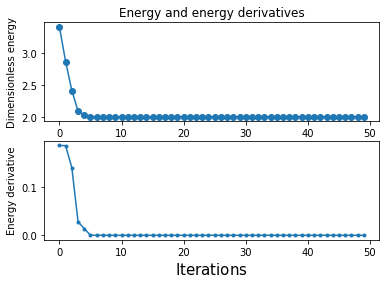

       Alpha    Energy    Derivative
0   2.106134  3.404946  1.858033e-01
1   1.734527  2.861062  1.853368e-01
2   1.363854  2.408195  1.398050e-01
3   1.084244  2.088972  2.796540e-02
4   1.028313  2.026826  1.376382e-02
5   1.000785  2.000815  2.702662e-04
6   1.000245  2.000235  1.170720e-04
7   1.000010  2.000011  5.287534e-06
8   1.000000  2.000000 -5.720087e-08
9   1.000000  2.000000  1.367980e-09
10  1.000000  2.000000  1.557199e-10
11  1.000000  2.000000  1.081224e-11
12  1.000000  2.000000  1.020517e-12
13  1.000000  2.000000 -1.441069e-13
14  1.000000  2.000000 -8.881784e-16
15  1.000000  2.000000 -1.998401e-15
16  1.000000  2.000000 -3.108624e-15
17  1.000000  2.000000 -8.215650e-15
18  1.000000  2.000000 -6.661338e-15
19  1.000000  2.000000  2.042810e-14
20  1.000000  2.000000 -8.881784e-16
21  1.000000  2.000000 -1.776357e-15
22  1.000000  2.000000 -1.776357e-15
23  1.000000  2.000000 -2.664535e-15
24  1.000000  2.000000 -5.773160e-15
25  1.000000  2.000000  1.776357e-15
2

In [5]:

#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
x0 = 0.5
# Set up iteration using stochastic gradient method
Energy =0 ; EnergyDer = 0
Energy, EnergyDer = EnergyMinimization(x0)

# No adaptive search for a minimum
eta = 2.0
Niterations = 50

Energies = np.zeros(Niterations)
EnergyDerivatives = np.zeros(Niterations)
AlphaValues = np.zeros(Niterations)
Totiterations = np.zeros(Niterations)

for iter in range(Niterations):
    gradients = EnergyDer
    x0 -= eta*gradients
    Energy, EnergyDer = EnergyMinimization(x0)
    Energies[iter] = Energy
    EnergyDerivatives[iter] = EnergyDer
    AlphaValues[iter] = x0
    Totiterations[iter] = iter

plt.subplot(2, 1, 1)
plt.plot(Totiterations, Energies, 'o-')
plt.title('Energy and energy derivatives')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(Totiterations, EnergyDerivatives, '.-')
plt.xlabel(r'$\mathrm{Iterations}$', fontsize=15)
plt.ylabel('Energy derivative')
save_fig("QdotNonint")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Derivative':EnergyDerivatives}

frame = pd.DataFrame(data)
print(frame)

We see that the first derivative becomes smaller and smaller and after
some forty iterations, it is for all practical purposes almost
vanishing. The exact energy is $2.0$ and the optimal variational
parameter is $1.0$, as it should.

Next, we extend the above code to include the Coulomb interaction and the Jastrow factor as well. This is done here.

In [9]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
# Common imports
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyMinimization(alpha, beta):

    NumberMCcycles= 10000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = np.zeros((2), np.double)
    DeltaPsi = np.zeros((2), np.double)
    DerivativePsiE = np.zeros((2), np.double)
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
alpha = 0.95
beta = 0.3
# Set up iteration using stochastic gradient method
Energy = 0
EDerivative = np.zeros((2), np.double)
# Learning rate eta, max iterations, need to change to adaptive learning rate
eta = 0.01
MaxIterations = 50
iter = 0

Energies = np.zeros(MaxIterations)
EnergyDerivatives1 = np.zeros(MaxIterations)
EnergyDerivatives2 = np.zeros(MaxIterations)
AlphaValues = np.zeros(MaxIterations)
BetaValues = np.zeros(MaxIterations)

while iter < MaxIterations:
    Energy, EDerivative = EnergyMinimization(alpha,beta)
    alphagradient = EDerivative[0]
    betagradient = EDerivative[1]
    alpha -= eta*alphagradient
    beta -= eta*betagradient 
    Energies[iter] = Energy
    EnergyDerivatives1[iter] = EDerivative[0] 
    EnergyDerivatives2[iter] = EDerivative[1] 
    AlphaValues[iter] = alpha
    BetaValues[iter] = beta
    iter += 1

#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
pd.set_option('max_columns', 6)
data ={'Alpha':AlphaValues,'Beta':BetaValues,'Energy':Energies,'Alpha Derivative':EnergyDerivatives1,'Beta Derivative':EnergyDerivatives2}

frame = pd.DataFrame(data)
print(frame)

       Alpha      Beta    Energy  Alpha Derivative  Beta Derivative
0   0.952592  0.302035  3.031603         -0.259169        -0.203463
1   0.954800  0.303889  3.014805         -0.220836        -0.185417
2   0.957295  0.305764  3.034988         -0.249499        -0.187551
3   0.959293  0.307569  3.003745         -0.199835        -0.180475
4   0.961355  0.309249  3.011721         -0.206125        -0.168031
5   0.963274  0.310797  3.023720         -0.191947        -0.154730
6   0.965195  0.312426  3.015357         -0.192116        -0.162978
7   0.967183  0.314049  3.012655         -0.198770        -0.162283
8   0.968893  0.315413  3.005537         -0.170982        -0.136384
9   0.970492  0.316825  2.998850         -0.159910        -0.141155
10  0.972170  0.318206  3.000353         -0.167773        -0.138089
11  0.973665  0.319524  3.008301         -0.149515        -0.131863
12  0.975047  0.320800  3.008239         -0.138249        -0.127553
13  0.976424  0.321993  3.005048         -0.1376

The exact energy is $3.0$ for an oscillator frequency $\omega =1$
(with $\hbar =1$). We note however that with this learning rate and
number of iterations, the energies and the derivatives are not yet
converged.

We can improve upon this by using the algorithms provided by the **optimize** package in Python.
One of these algorithms is  Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm. 

The optimization problem is to minimize $f(\mathbf {x} )$ where
$\mathbf {x}$ is a vector in $R^{n}$, and $f$ is a differentiable
scalar function. There are no constraints on the values that $\mathbf{x}$ can take.

The algorithm begins at an initial estimate for the optimal value
$\mathbf {x}_{0}$ and proceeds iteratively to get a better estimate at
each stage.

The search direction $p_k$ at stage $k$ is given by the solution of the analogue of the Newton equation

$$
B_{k}\mathbf {p} _{k}=-\nabla f(\mathbf {x}_{k}),
$$

where $B_{k}$ is an approximation to the Hessian matrix, which is
updated iteratively at each stage, and $\nabla f(\mathbf {x} _{k})$
is the gradient of the function
evaluated at $x_k$. 
A line search in the direction $p_k$ is then used to
find the next point $x_{k+1}$ by minimising

$$
f(\mathbf {x}_{k}+\alpha \mathbf {p}_{k}),
$$

over the scalar $\alpha > 0$.


The modified code here uses the BFGS algorithm but performs now a
production run and writes to file all average values of the
energy.

In [10]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
import sys
import os

# Where to save data files
PROJECT_ROOT_DIR = "Results"
DATA_ID = "Results/EnergyMin"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

outfile = open(data_path("Energies.dat"),'w')


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyDerivative(x0):

    
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0 
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return EnergyDer


# Computing the expectation value of the local energy 
def Energy(x0):
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        energy += DeltaE
        if Printout: 
           outfile.write('%f\n' %(energy/(MCcycle+1.0)))            
    # We calculate mean values
    energy /= NumberMCcycles
    return energy

#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# seed for rng generator 
seed()
# Monte Carlo cycles for parameter optimization
Printout = False
NumberMCcycles= 10000
# guess for variational parameters
x0 = np.array([0.9,0.2])
# Using Broydens method to find optimal parameters
res = minimize(Energy, x0, method='BFGS', jac=EnergyDerivative, options={'gtol': 1e-4,'disp': True})
x0 = res.x
# Compute the energy again with the optimal parameters and increased number of Monte Cycles
NumberMCcycles= 2**19
Printout = True
FinalEnergy = Energy(x0)
EResult = np.array([FinalEnergy,FinalEnergy])
outfile.close()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Optimal Parameters':x0, 'Final Energy':EResult}
frame = pd.DataFrame(data)
print(frame)

         Current function value: 2.995310
         Iterations: 2
         Function evaluations: 23
         Gradient evaluations: 12
   Optimal Parameters  Final Energy
0            1.006790      3.000609
1            0.428678      3.000609


Note that the **minimize** function returns the final values for the
variable $\alpha=x0[0]$ and $\beta=x0[1]$ in the array $x$.

When we have found the minimum, we use these optimal parameters to perform a production run of energies.
The output is in turn written to file and is used, together with resampling methods like the **blocking method**,
to obtain the best possible estimate for the standard deviation.   The optimal minimum is, even with our guess, rather close to the exact value of $3.0$ a.u.

The [sampling
functions](https://github.com/CompPhysics/ComputationalPhysics2/tree/gh-pages/doc/Programs/Resampling)
can be used to perform both a blocking analysis, or a standard
bootstrap and jackknife analysis.

### How do we proceed?

There are several paths which can be chosen. One is to extend the
brute force gradient descent method with an adapative stochastic
gradient. There are several examples of this. A recent approach based
on [the Langevin equations](https://arxiv.org/pdf/1805.09416.pdf)
seems like a promising approach for general and possibly non-convex
optimization problems.

Here we would like to point out that our next step is now to use the
optimal values for our variational parameters and use these as inputs
to a production run. Here we would output values of the energy and
perform for example a blocking analysis of the results in order to get
a best possible estimate of the standard deviation.



## Resampling analysis

The next step is then to use the above data sets and perform a
resampling analysis, either using say the Bootstrap method or the
Blocking method. Since the data will be correlated, we would recommend
to use the non-iid Bootstrap code here. The theoretical background for these resampling methods is found in the [statistical analysis lecture notes](http://compphysics.github.io/ComputationalPhysics2/doc/pub/statanalysis/html/statanalysis.html)

Here we have tailored the codes to the output file from the previous example. We present first the bootstrap resampling with non-iid stochastic event.

In [19]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import std, mean, concatenate, arange, loadtxt, zeros, ceil
from numpy.random import randint
from time import time


def tsboot(data,statistic,R,l):
    t = zeros(R); n = len(data); k = int(ceil(float(n)/l));
    inds = arange(n); t0 = time()
    
    # time series bootstrap
    for i in range(R):
        # construct bootstrap sample from
        # k chunks of data. The chunksize is l
        _data = concatenate([data[j:j+l] for j in randint(0,n-l,k)])[0:n];
        t[i] = statistic(_data)

    # analysis
    print ("Runtime: %g sec" % (time()-t0)); print ("Bootstrap Statistics :")
    print ("original           bias      std. error")
    print ("%8g %14g %15g" % (statistic(data), \
                             mean(t) - statistic(data), \
                             std(t) ))
    return t
# Read in data
X = loadtxt(infile)
# statistic to be estimated. Takes two args.
# arg1: the data
def stat(data):
    return mean(data)
t = tsboot(X, stat, 2**12, 2**10)

The blocking code, based on the article of [Marius Jonsson](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304) is given here

In [20]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, sqrt
from numpy.linalg import inv

def block(x):
    # preliminaries
    n = len(x)
    d = int(log2(n))
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)

    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
   
    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,9.210340, 11.344867, 13.276704, 15.086272, 16.811894, 18.475307, 20.090235, 21.665994, 23.209251, 24.724970, 26.216967, 27.688250, 29.141238, 30.577914, 31.999927, 33.408664, 34.805306, 36.190869, 37.566235, 38.932173, 40.289360, 41.638398, 42.979820, 44.314105, 45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")
    return mu, s[k]/2**(d-k)


x = loadtxt(infile)
(mean, var) = block(x) 
std = sqrt(var)
import pandas as pd
from pandas import DataFrame
data ={'Mean':[mean], 'STDev':[std]}
frame = pd.DataFrame(data,index=['Values'])
print(frame)

## Additional notes

What we have not done here is to parallelize the codes. This material will be added later. 
The material we have developed serves thus the aim to bridge the gap between traditional Monte Carlo calculations and Machine Learning methods. The most important ingredients here are 
1. The definition of the cost function (in our case the energy as function of the variational parameters)

2. The optimization methods like gradient descent and stochastic gradient descent

3. Metropolis sampling (and later also Gibbs sampling) and Markov chain Monte Carlo approaches

We will meet these concepts again in our notes on Boltzmann machines (notebook 2) and on shadow wave functions (notebook 3).